# references
#   https://datascience.stackexchange.com/questions/29520/how-to-plot-learning-curve-and-validation-curve-while-using-pipeline

In [58]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing.label import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC 



from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report




In [45]:
data = 'wine'
if data == 'wine':
    df = pd.read_csv(r'..\data\winequality-white.csv', sep=';')
    
print(df.shape)
print(df.info())

(4898, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


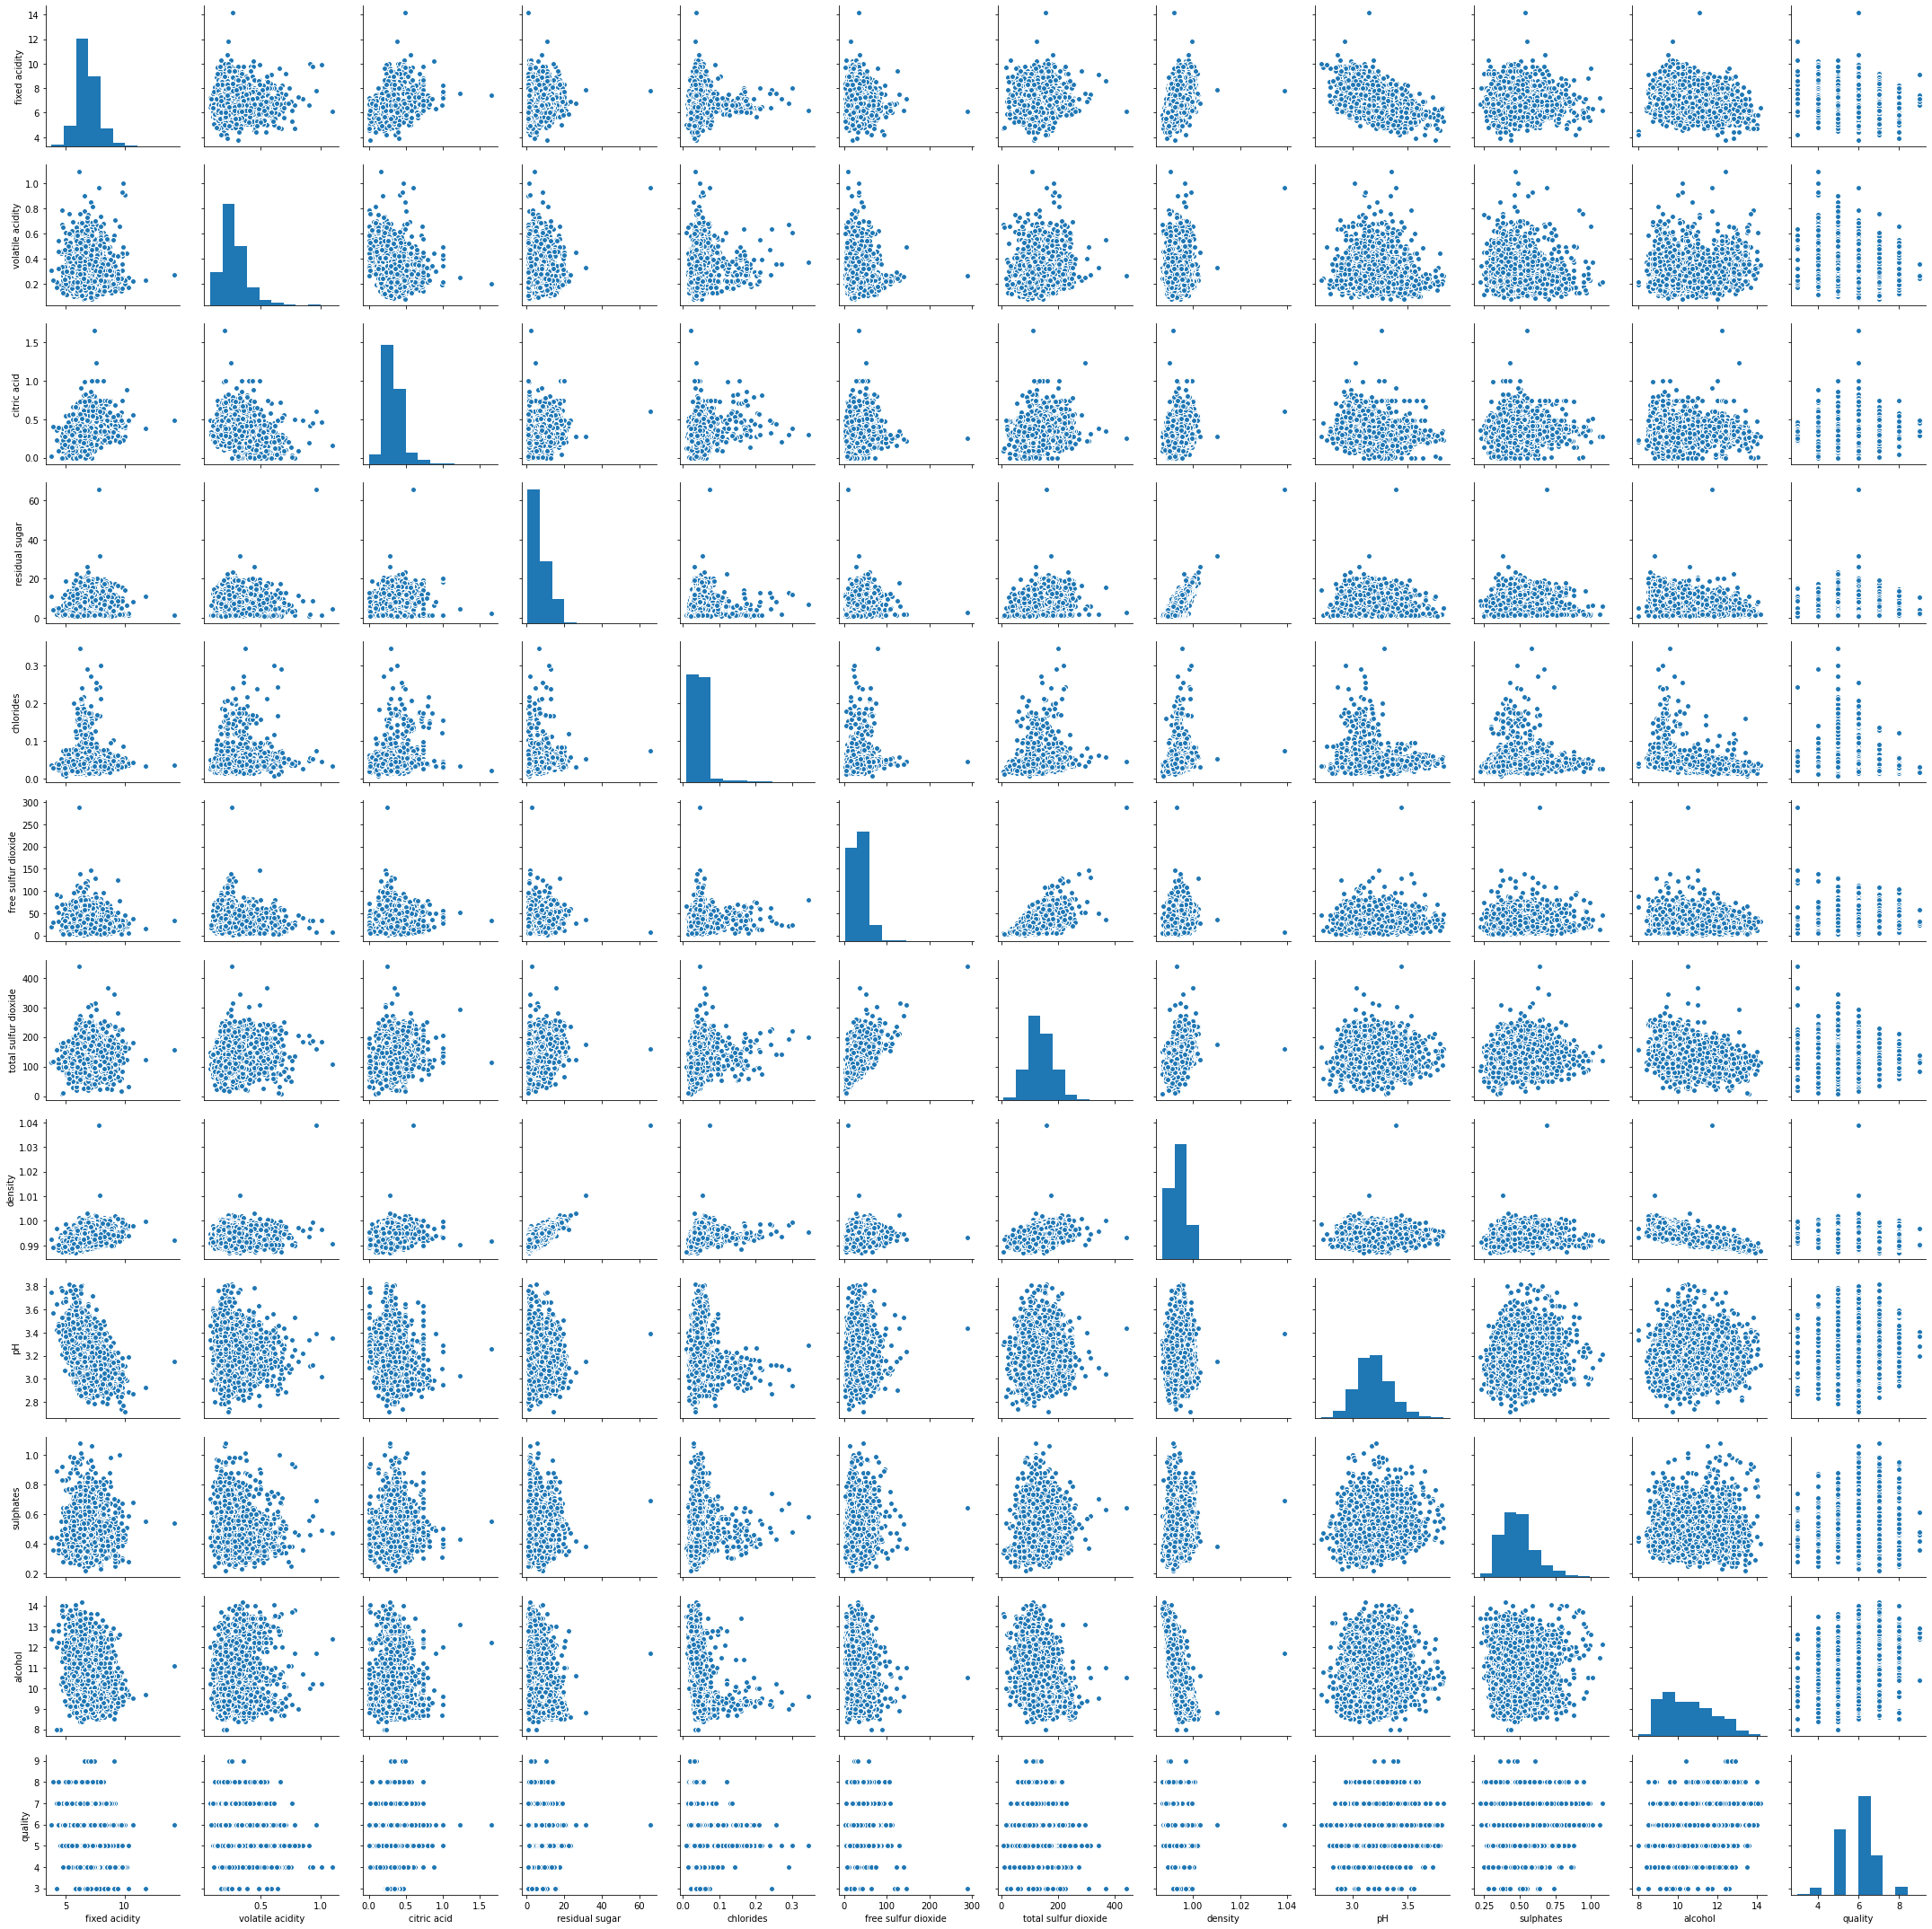

<Figure size 1440x1440 with 0 Axes>

In [11]:
plt.rcParams["figure.figsize"] = (20,20)
# Basic correlogram
sns.pairplot(df)
plt.show()
plt.savefig(r'..\plot\{}_scatterplot.png'.format(data), figsize=(20, 20))


In [46]:
y = df['quality'] >= 7

X = df.drop(columns='quality')

#enc = LabelEncoder()
#y = enc.fit_transform(df.quality)

print(X.shape)
print(y.shape)
print(X.head())
print('====')
#print(y.head())
y

(4898, 11)
(4898,)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  
0      8.8  
1      9.5  
2     10.1  
3      9.9  
4 

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13       True
14      False
15       True
16      False
17       True
18      False
19      False
20       True
21       True
22       True
23      False
24      False
25      False
26      False
27      False
28      False
29       True
        ...  
4868    False
4869    False
4870     True
4871    False
4872    False
4873    False
4874    False
4875    False
4876     True
4877    False
4878    False
4879    False
4880    False
4881    False
4882    False
4883    False
4884    False
4885    False
4886     True
4887     True
4888    False
4889    False
4890    False
4891    False
4892    False
4893    False
4894    False
4895    False
4896     True
4897    False
Name: quality, Length: 4898, dtype: bool


# TRAIN TEST SPLIT

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.rcParams["figure.figsize"] = (10,10)

# DECISION TREE

1.0
0.5925170068027211
0.5925170068027211
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
{'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'class_weight': None, 'presort': 'deprecated', 'ccp_alpha': 0.0}


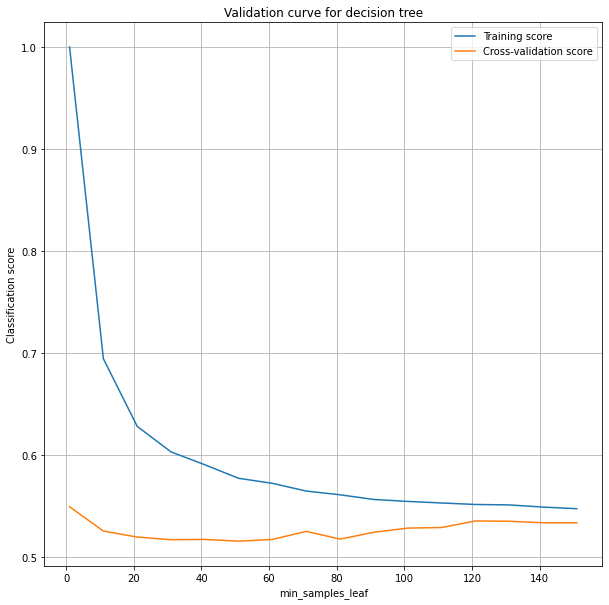

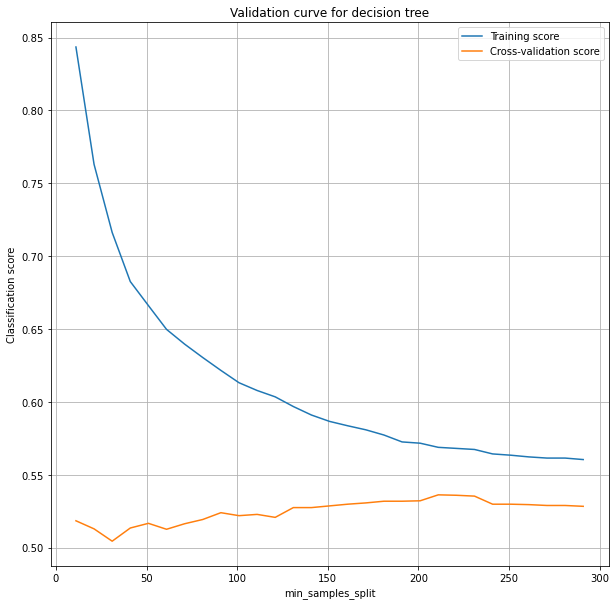

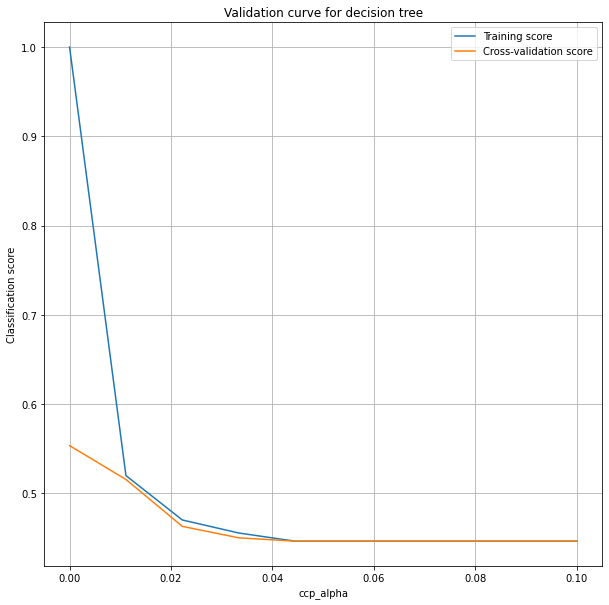

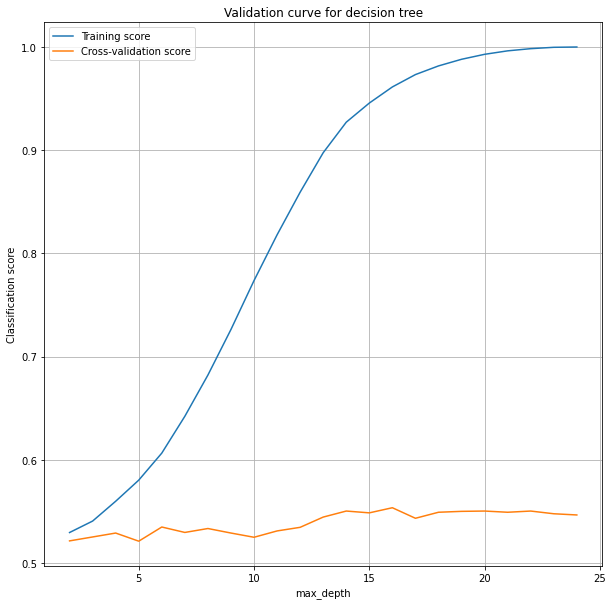

In [23]:


pipe = Pipeline([('std', StandardScaler()), ('cfr', DecisionTreeClassifier())])

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))


min_samples_leaf_range = np.arange(1, 21, 1)
print(min_samples_leaf_range)
print(vars(DecisionTreeClassifier()))


min_samples_leaf_range = np.arange(1, 160, 10)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__min_samples_leaf", param_range=min_samples_leaf_range, cv=5)


plt.figure()
#plt.xticks(min_samples_leaf_range)
plt.plot(min_samples_leaf_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(min_samples_leaf_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('min_samples_leaf')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()

plt.savefig(r'..\plot\{}_val_curve_min_samples_leaf.png'.format(data), figsize=(20, 20))
plt.show()

min_samples_split_range = np.arange(1, 300, 10) 
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__min_samples_split", param_range=min_samples_split_range, cv=5)

plt.figure()
#plt.xticks(min_samples_split_range)
plt.plot(min_samples_split_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(min_samples_split_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('min_samples_split')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(r'..\plot\{}_val_curve_min_samples_split.png'.format(data), figsize=(20, 20))

plt.show()

ccp_alpha_range = np.linspace(0, 0.1, 10)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__ccp_alpha", param_range=ccp_alpha_range, cv=5)

plt.figure()
#plt.xticks(ccp_alpha_range)
plt.plot(ccp_alpha_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(ccp_alpha_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('ccp_alpha')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(r'..\plot\{}_val_curve_ccp_alpha.png'.format(data), figsize=(20, 20))
plt.show()

max_depth_range = np.arange(2,25,1)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__max_depth", param_range=max_depth_range, cv=5)
plt.figure()
#plt.xticks(max_depth_range)
plt.plot(max_depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(max_depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(r'..\plot\{}_val_curve_max_depth.png'.format(data), figsize=(20, 20))
plt.show()



In [24]:
param_grid = {'cfr__min_samples_split': min_samples_split_range, 
              "cfr__min_samples_leaf": min_samples_leaf_range,
              "cfr__ccp_alpha": ccp_alpha_range,
              "cfr__max_depth": max_depth_range
              }
cv = StratifiedKFold(n_splits=5, random_state=42)
dt_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
dt_cv.fit(X_train, y_train)
print("Tuned dt best params: {}".format(dt_cv.best_params_))

ypred = dt_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = dt_cv.predict(X_test)
print(classification_report(y_test, ypred2))

Tuned rg best params: {'dt__ccp_alpha': 0.0, 'dt__max_depth': 7, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 211}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        13
           4       1.00      0.03      0.06       123
           5       0.61      0.61      0.61      1031
           6       0.55      0.74      0.63      1530
           7       0.56      0.30      0.39       600
           8       0.00      0.00      0.00       126
           9       0.00      0.00      0.00         5

    accuracy                           0.57      3428
   macro avg       0.39      0.24      0.24      3428
weighted avg       0.56      0.57      0.53      3428

######################
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        40
           5       0.57      0.59      0.58       426
           6       0.52      0.70      0.

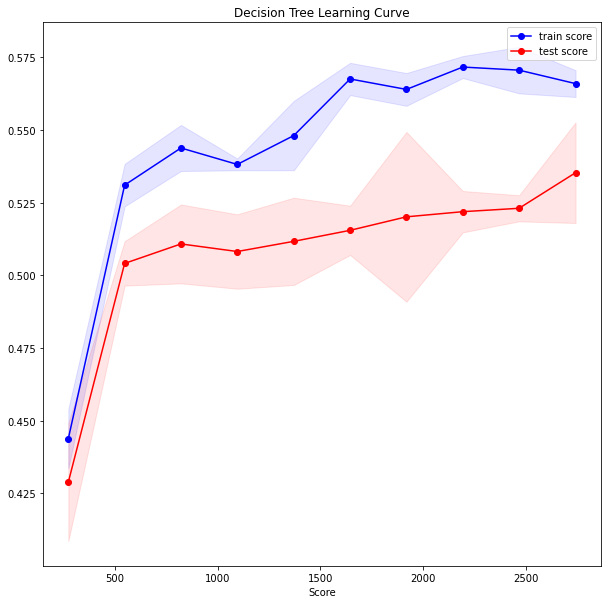

In [29]:
train_sizes, train_scores, test_scores = learning_curve(estimator=dt_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('Decision Tree Learning Curve')
plt.xlabel('Score')
#plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# SVM

In [ ]:
pipe = Pipeline([('std', StandardScaler()), ('cfr', SVC())])

print(vars(SVC()))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

C_range = np.logspace(-2, 3, 6)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__C", param_range=C_range, cv=5, n_jobs=-1)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

gamma_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__gamma", param_range=gamma_range, cv=5, n_jobs=-1)

plt.figure()
plt.semilogx(gamma_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(gamma_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel(r'$\gamma$')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

kernel_options = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__kernel", param_range=kernel_options, cv=5, n_jobs=-1)

plt.figure()
plt.plot(kernels_options, np.mean(train_scores, axis=1), label='Training score')
plt.plot(kernels_options, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM')
plt.xlabel(r'kernels')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()



In [43]:
param_grid = {'cfr__C': C_range,
              'cfr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'cfr__gamma': gamma_range
              }
cv = StratifiedKFold(n_splits=5, random_state=42)
svc_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
svc_cv.fit(X_train, y_train)
print("Tuned SVC best params: {}".format(svc_cv.best_params_))

ypred = svc_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = dt_cv.predict(X_test)
print(classification_report(y_test, ypred2))

KeyboardInterrupt: 

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator=svc_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('Support Vector Machine Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# kNN

{'n_neighbors': 5, 'radius': None, 'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'p': 2, 'n_jobs': None, 'weights': 'uniform'}
0.8771878646441074
0.8367346938775511
0.8367346938775511


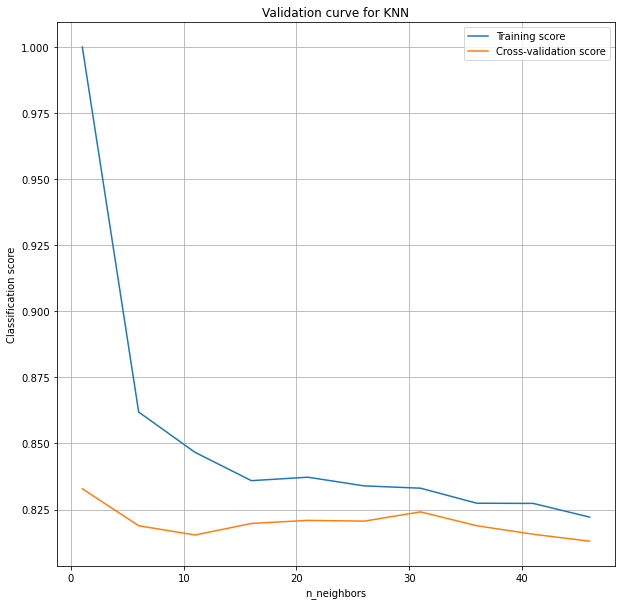

In [49]:
pipe = Pipeline([('std', StandardScaler()), ('cfr', KNeighborsClassifier())])

print(vars(KNeighborsClassifier()))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

n_neighbors_range = np.arange(1, 50, 5)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__n_neighbors", param_range=n_neighbors_range, cv=5, n_jobs=-1)

plt.figure()
plt.plot(n_neighbors_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_neighbors_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for KNN')
plt.xlabel('n_neighbors')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

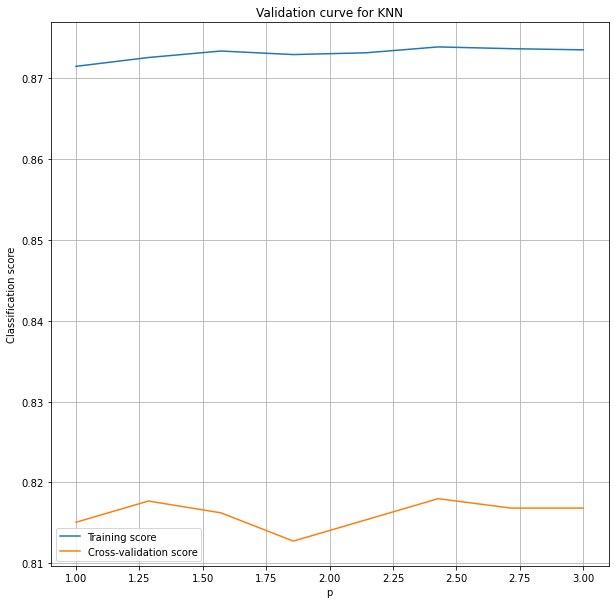

In [52]:
p_range = np.linspace(1, 3, 8)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__p", param_range=p_range, cv=5, n_jobs=-1)

plt.figure()
plt.plot(p_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(p_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for KNN')
plt.xlabel('p')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

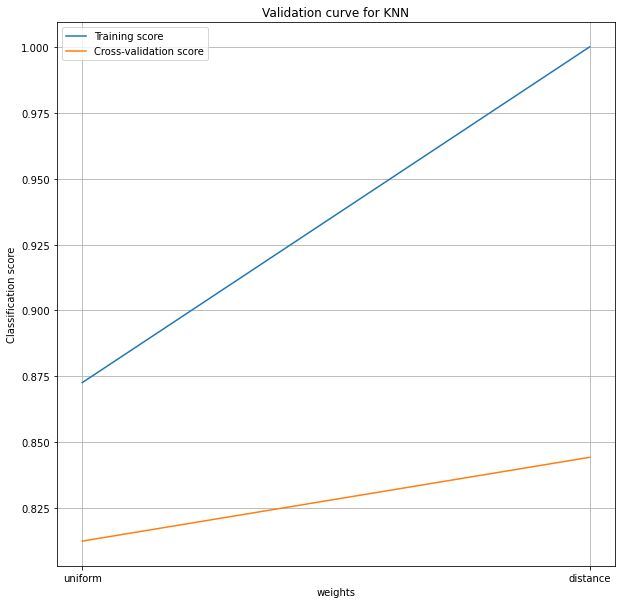

In [55]:
weights = ['uniform', 'distance']
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__weights", param_range=weights, cv=5, n_jobs=-1)

plt.figure()
plt.plot(weights, np.mean(train_scores, axis=1), label='Training score')
plt.plot(weights, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for KNN')
plt.xlabel('weights')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [56]:
param_grid = {'cfr__n_neighbors': n_neighbors_range,
              'cfr__weights': weights,
              'cfr__p': p_range
              }

cv = StratifiedKFold(n_splits=5, random_state=42)
knn_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
knn_cv.fit(X_train, y_train)
print("Tuned KNN best params: {}".format(knn_cv.best_params_))

ypred = knn_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = knn_cv.predict(X_test)
print(classification_report(y_test, ypred2))

Tuned KNN best params: {'cfr__n_neighbors': 36, 'cfr__p': 2.4285714285714284, 'cfr__weights': 'distance'}
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2697
        True       1.00      1.00      1.00       731

    accuracy                           1.00      3428
   macro avg       1.00      1.00      1.00      3428
weighted avg       1.00      1.00      1.00      3428

######################
              precision    recall  f1-score   support

       False       0.89      0.97      0.92      1141
        True       0.83      0.57      0.68       329

    accuracy                           0.88      1470
   macro avg       0.86      0.77      0.80      1470
weighted avg       0.87      0.88      0.87      1470



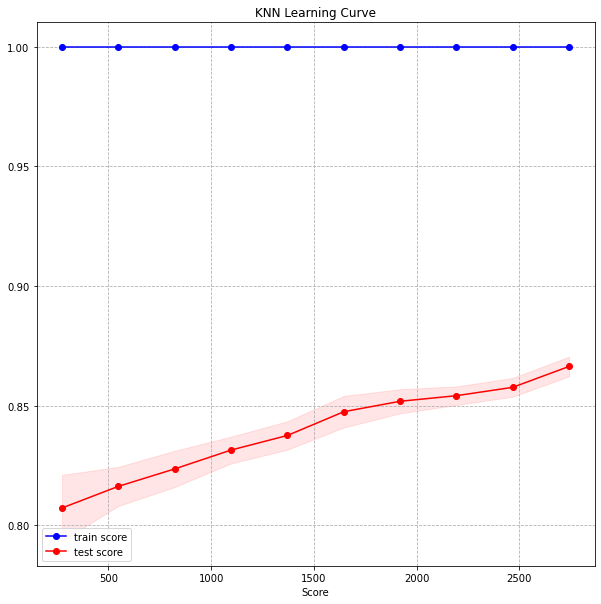

In [57]:
train_sizes, train_scores, test_scores = learning_curve(estimator=knn_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('KNN Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# ANN

{'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 200, 'loss': 'log_loss', 'hidden_layer_sizes': (100,), 'shuffle': True, 'random_state': None, 'tol': 0.0001, 'verbose': False, 'warm_start': False, 'momentum': 0.9, 'nesterovs_momentum': True, 'early_stopping': False, 'validation_fraction': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'n_iter_no_change': 10, 'max_fun': 15000}
0.8573512252042007
0.8224489795918367
0.8224489795918367


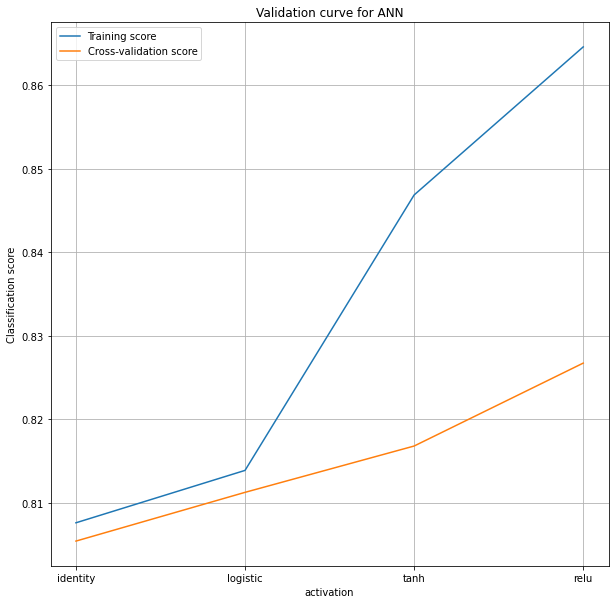

In [61]:
pipe = Pipeline([('std', StandardScaler()), ('cfr', MLPClassifier())])

print(vars(MLPClassifier()))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

activation = ['identity', 'logistic', 'tanh', 'relu']
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__activation", param_range=activation, cv=5, n_jobs=-1)

plt.figure()
plt.plot(activation, np.mean(train_scores, axis=1), label='Training score')
plt.plot(activation, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for ANN')
plt.xlabel('activation')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

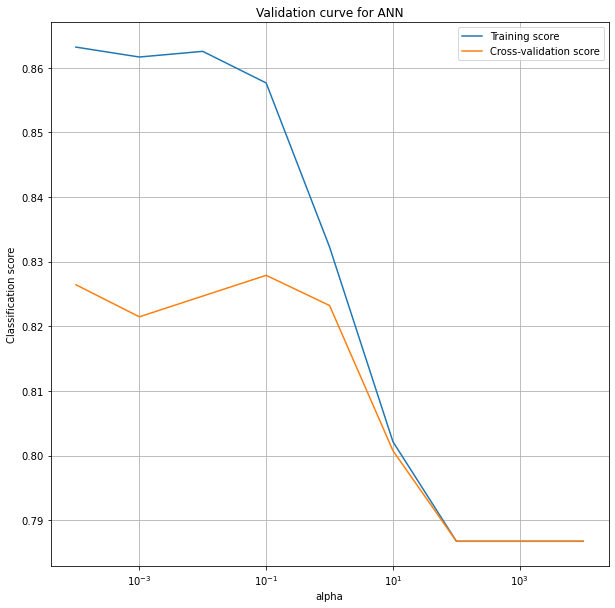

In [64]:
alpha = np.logspace(-4, 4, 9)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__alpha", param_range=alpha, cv=5, n_jobs=-1)

plt.figure()
plt.semilogx(alpha, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(alpha, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for ANN')
plt.xlabel('alpha')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [65]:
param_grid = {'cfr__alpha': alpha,
              }

cv = StratifiedKFold(n_splits=5, random_state=42)
ann_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
ann_cv.fit(X_train, y_train)
print("Tuned ANN best params: {}".format(knn_cv.best_params_))

ypred = ann_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = ann_cv.predict(X_test)
print(classification_report(y_test, ypred2))

Tuned ANN best params: {'cfr__n_neighbors': 36, 'cfr__p': 2.4285714285714284, 'cfr__weights': 'distance'}
              precision    recall  f1-score   support

       False       0.88      0.95      0.91      2697
        True       0.74      0.53      0.62       731

    accuracy                           0.86      3428
   macro avg       0.81      0.74      0.77      3428
weighted avg       0.85      0.86      0.85      3428

######################
              precision    recall  f1-score   support

       False       0.85      0.94      0.89      1141
        True       0.67      0.42      0.52       329

    accuracy                           0.83      1470
   macro avg       0.76      0.68      0.71      1470
weighted avg       0.81      0.83      0.81      1470



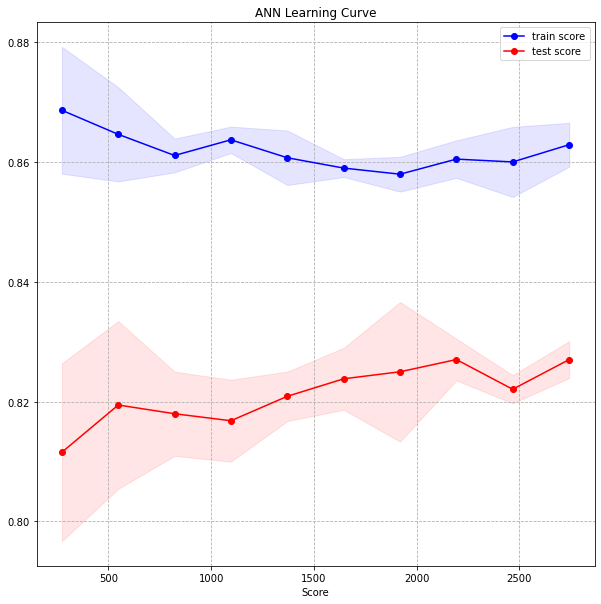

In [66]:
train_sizes, train_scores, test_scores = learning_curve(estimator=ann_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('ANN Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()